In [1]:
# !pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
  
#   print(
#       'User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn]))
#   )
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [3]:
# !kaggle competitions download "titanic"

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 55.9MB/s]


In [4]:
# !unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

SEED = 42

Feature Analysis

In [31]:
print(train_df.info())
train_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
771,772,0,3,"Jensen, Mr. Niels Peder",male,48.0,0,0,350047,7.8542,NaN,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
402,403,0,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,S


In [32]:
print(test_df.info())
test_df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
356,1248,1,"Brown, Mrs. John Murray (Caroline Lane Lamson)",female,59.0,2,0,11769,51.4792,C101,S
387,1279,2,"Ashby, Mr. John",male,57.0,0,0,244346,13.0000,NaN,S
189,1081,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S


Feature Engineering

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [34]:
IDtest = test_df["PassengerId"]
Outliers_to_drop = [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [35]:
dataset =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [36]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [37]:
# Convert to categorical values Title 
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [38]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [39]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [40]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [41]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [42]:
dataset.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fsize', 'Single',
       'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
       'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'T_A', 'T_A4',
       'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C', 'T_CA', 'T_CASOTON', 'T_FC',
       'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC', 'T_PP', 'T_PPP', 'T_SC',
       'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW', 'T_SCPARIS', 'T_SCParis',
       'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2', 'T_SOTONOQ', 'T_SP', 'T_STONO',
       'T_STONO2', 'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP', 'T_X', 'Pc_1',
       'Pc_2', 'Pc_3'],
      dtype='object')

Model Engineering

In [43]:
train_len = len(train_df)
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [44]:
## Separate train features and label 
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)

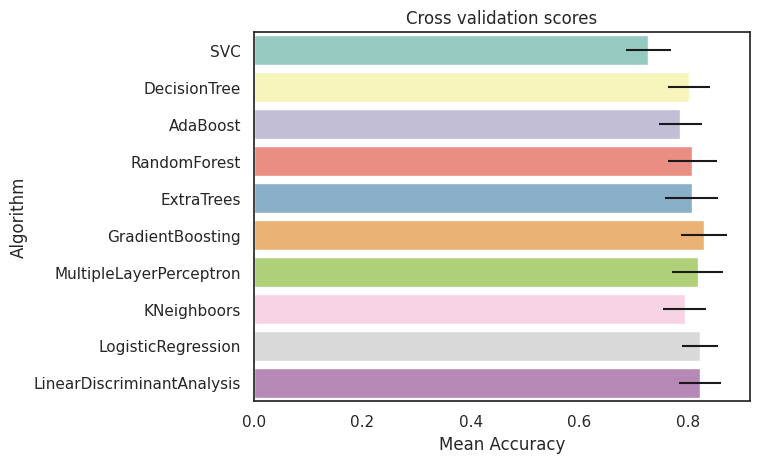

In [47]:
# Modeling step Test differents algorithms 
kfold = StratifiedKFold(n_splits=10)
random_state = SEED
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Predictions

In [48]:
n_jobs = 2

In [49]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=SEED)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8229954034729315

In [50]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [51]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737489

In [52]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8297242083758938

In [53]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= n_jobs, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

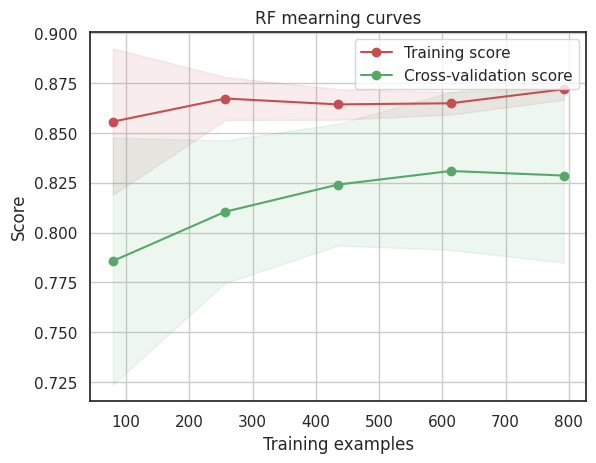

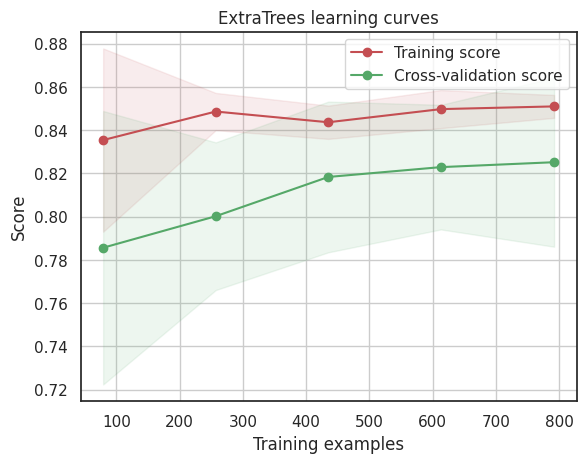

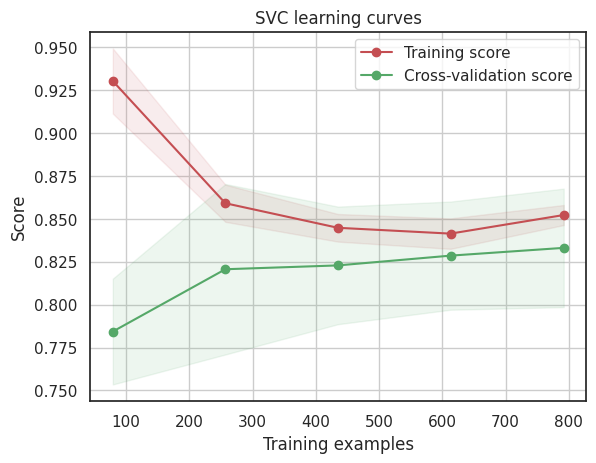

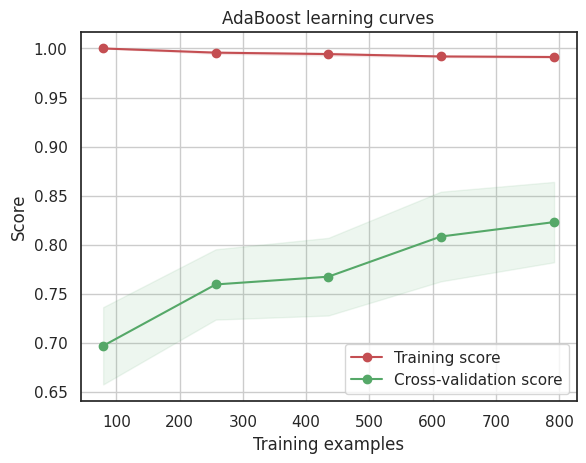

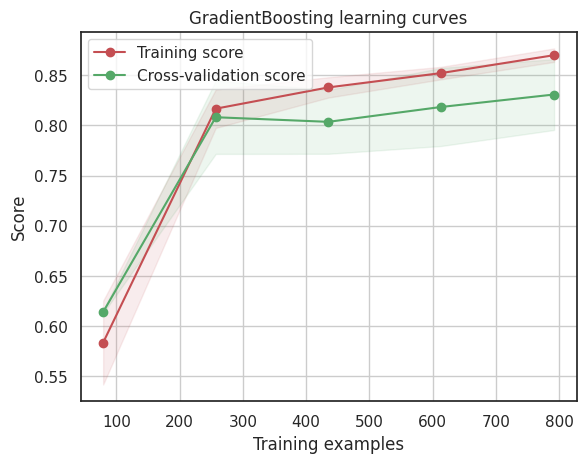

In [54]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

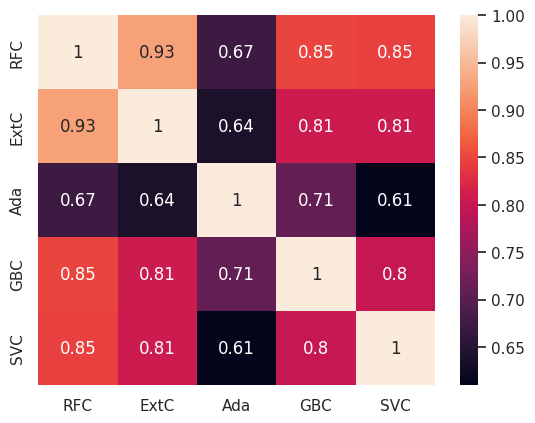

In [55]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [58]:
print(gsSVMC.best_score_)
print(gsGBC.best_score_)
print(gsRFC.best_score_)
print(gsExtC.best_score_)
print(gsadaDTC.best_score_)

0.8331332992849847
0.8297242083758938
0.8308861082737489
0.8320097037793668
0.8229954034729315


In [61]:
votingC = VotingClassifier(estimators=[
    # ('rfc', RFC_best), 
    # ('extc', ExtC_best),
    ('svc', SVMC_best), 
    # ('adac',ada_best),
    # ('gbc',GBC_best)
    ], voting='soft', n_jobs=n_jobs)

votingC = votingC.fit(X_train, Y_train)

In [62]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("submissions_18.csv",index=False)